# GAN (Generative adversarial networks)

출처 : https://github.com/Sunghee-SDL/Keras-GAN/blob/master/gan/gan.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

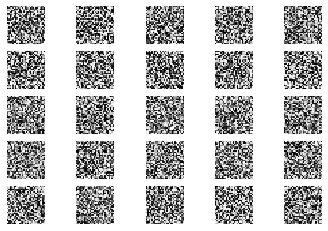

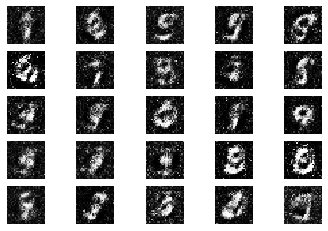

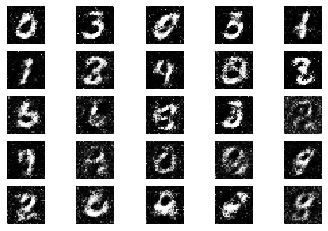

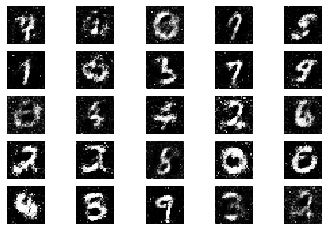

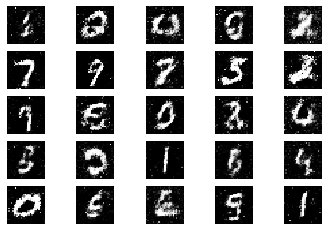

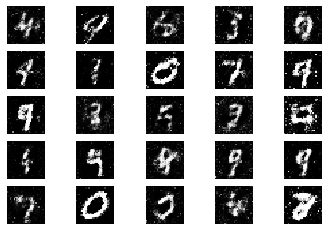

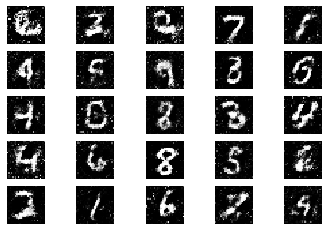

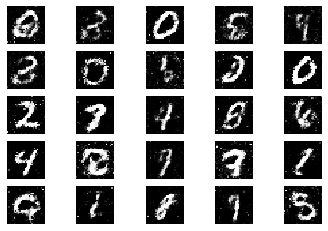

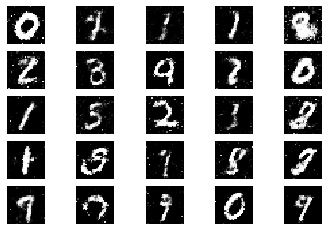

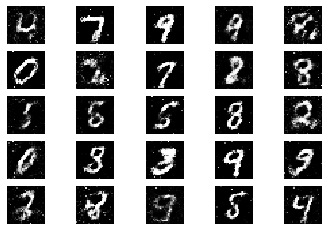

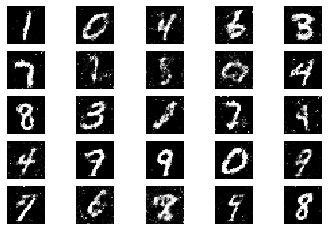

In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np


# ---------------------
#  파라미터 설정, model build, compile
# ---------------------

class GAN():
    def __init__(self):
        # input shape 설정. (mnist 이미지 크기)
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        # 노이즈의 dimension
        self.latent_dim = 100
        
        optimizer = Adam(0.0002, 0.5)
        
        # discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer = optimizer,
                                  metrics = ['accuracy'])
        
        # generator 모델 생성
        self.generator = self.build_generator()
        
        # noise 들어갈 z텐서 생성 후, generator에 z 넣어줌.
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
        self.discriminator.trainable = False
        
        # discriminator에 이미지와 라벨을 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
        validity = self.discriminator(img)
                
        # generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
        # discriminator를 속이도록 generator를 학습
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        
    # ---------------------
    #  Generator 모델 구성 (input : noise / output : image)
    # ---------------------    
        
    def build_generator(self):
        
        model = Sequential()
        
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
                  
        model.summary()
        
        # noise 텐서 생성, model에 noise 넣으면 이미지 나옴
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)
    
    
    # ---------------------
    #  Discriminator 모델 구성 (input : image / output : 판별값(0에서 1사이의 숫자))
    # ---------------------    
    
    def build_discriminator(self):
        
        model = Sequential()
        
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        # 이미지 들어갈 텐서 생성, model에 넣으면 판별값 나옴
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    
    # ---------------------
    #  학습 및 실행
    # ---------------------   
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        # mnist 데이터 셋 불러옴 (이미지만 필요해서 y 라벨 필요 없음)
        (X_train, __), (__, __) = mnist.load_data()
        
        # 이미지 전처리(Rescale -1 to 1), input shape(60000, 28, 28, 1)로 확장
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        # 정답으로 사용 할 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise 생성(batch_size만큼)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # noise를 generator에 넣어서 fake image 이미지 생성
            gen_imgs = self.generator.predict(noise)
            
            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            
            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # noise 생성
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # noise가 들어가서 discriminator가 real image라고 판단하도록 generator를 학습
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # sample_interval(1000) epoch 마다 loss와 accuracy와 이미지 출력
            if epoch % sample_interval == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)
             
    # 이미지 출력
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
#             fig.savefig("images/%d.png" % epoch)
#         plt.close()
    
# GAN 실행
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10001, batch_size=32, sample_interval=1000)